In [1]:
import jupyros as jr # optional - for jupyter dev only
import ipyvolume as ipv # for pointcloud visualization

In [11]:
import cv2
import image_geometry as img_geo
import matplotlib.pyplot as plt
import numpy as np
import os
import pickle
import rosbag
import rospy
import tf

from pcl_helper import *
from cv_bridge import CvBridge, CvBridgeError
from geometry_msgs.msg import PoseStamped
from sensor_msgs.msg import Image, CameraInfo
from __future__ import print_function

In [12]:
%matplotlib inline

In [68]:
def view_pcl(X):
    if type(X)!='numpy.ndarray':
        N = np.asarray(X).T
    return ipv.quickscatter(N[0,], N[1,], N[2,], size=1, marker='point_2d')

### get an image
from `bag` or `publisher`. provides an `rgb` image and an `mm` depthimage.

In [69]:
bag = rosbag.Bag('../data/new_bin_with_screws.bag', "r")
bridge = CvBridge()

In [15]:
topics = ['/head_camera/rgb/image_raw', '/head_camera/depth_registered/image', '/head_camera/depth_registered/points']
for topic, msg, _ in bag.read_messages(topics=topics):
    if topic==topics[0]:
        rgb_img = bridge.imgmsg_to_cv2(msg, desired_encoding='passthrough')
    elif topic==topics[1]:
        depth_img = bridge.imgmsg_to_cv2(msg, desired_encoding='passthrough')
    else:
        cloud = ros_to_pcl(msg)

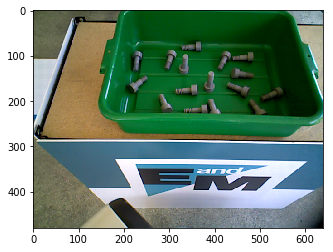

In [16]:
plt.imshow(rgb_img);

### mask green
to get bin outline

In [67]:
real_green, green_benchmark = None, 'green.pkl'
if green_benchmark not in os.listdir('.'):
    with open(green_benchmark, 'w') as f:
        pickle.dump(green_benchmark, f)
with open(green_benchmark, 'r') as f:
    real_green = pickle.load(f)

In [20]:
BIN_GREEN = np.mean(real_green, axis=0, dtype=int)
STDEV = 2.5*np.std(real_green, axis=0).astype(int)
ALPHA = 1.3

In [21]:
hc_img = np.clip(rgb_img * ALPHA, 0, 255).astype(np.uint8)
mask = cv2.inRange(hc_img, BIN_GREEN-STDEV, BIN_GREEN+STDEV)
res = cv2.bitwise_and(hc_img, hc_img, mask=mask)

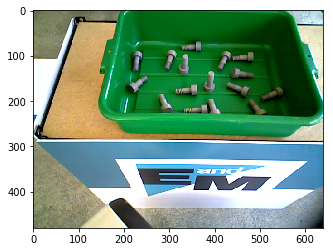

In [22]:
plt.imshow(hc_img)

### filter only bolts

In [23]:
gray_img = cv2.cvtColor(res, cv2.COLOR_BGR2GRAY)
_, contours, hierarchy = cv2.findContours(gray_img, 1, 2)

find convex hull of green bin


In [24]:
max_contour = contours[np.argmax([cv2.contourArea(c) for c in contours])]
EPSILON = 0.1*cv2.arcLength(max_contour, True)
hull = cv2.convexHull(cv2.approxPolyDP(max_contour, EPSILON, True))

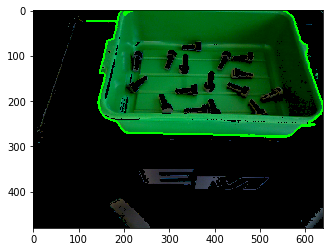

In [25]:
res2 = res.copy(); plt.imshow(cv2.drawContours(res2, [max_contour], -1, (0,255,0), 3))

a less dumb approach: RANSAC away flat planes in depth

### find dark blobs

In [26]:
HEIGHT_RANGE = int(0.3 * (np.max(hull[:,:,1]) - np.min(hull[:,:,1])))
WIDTH_RANGE = int(1.8 * HEIGHT_RANGE)

In [27]:
cx, cy = np.mean(hull, axis=0)[0].astype(int)
roi_origin = (cy-HEIGHT_RANGE), (cx-WIDTH_RANGE)
roi = res[cy-HEIGHT_RANGE:cy+HEIGHT_RANGE,\
   cx-WIDTH_RANGE:cx+WIDTH_RANGE,:]
roi[roi < np.array([50, 25, 50])] = 0 # threshold

In [28]:
gray_img = cv2.cvtColor(roi, cv2.COLOR_BGR2GRAY)
_, contours, hierarchy = cv2.findContours(gray_img, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)

In [29]:
areas = np.array([cv2.contourArea(c) for c in contours])
mean_area = np.mean(areas)
part_area = 0.6*mean_area
MIN_AREA, MAX_AREA = mean_area-part_area, mean_area+2*part_area

In [30]:
candidates = np.where((areas>MIN_AREA) & (areas<MAX_AREA))[0]

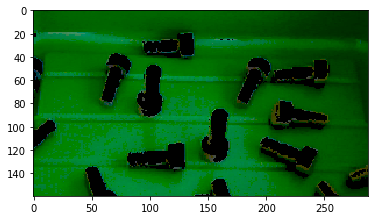

In [31]:
plt.imshow(roi)

### singulate a bolt
score = w * (dist from top of image + flatness of bounding box)

(as measures of greatest operating volume for end-effector & top-down surface area of bolt)

In [32]:
def bounding_box(contour):
    rect = cv2.minAreaRect(contour)
    box = np.int0(cv2.boxPoints(rect))
    x, y = np.mean(box[:,0]), np.mean(box[:,1])
    _, _, angle = cv2.fitEllipse(contour)
    return int(x), int(y), angle, box

In [33]:
def score(x, y, angle):
    dist_from_normal = abs((90.0-angle)/180.0)
    return y/480.0 + (1-dist_from_normal)

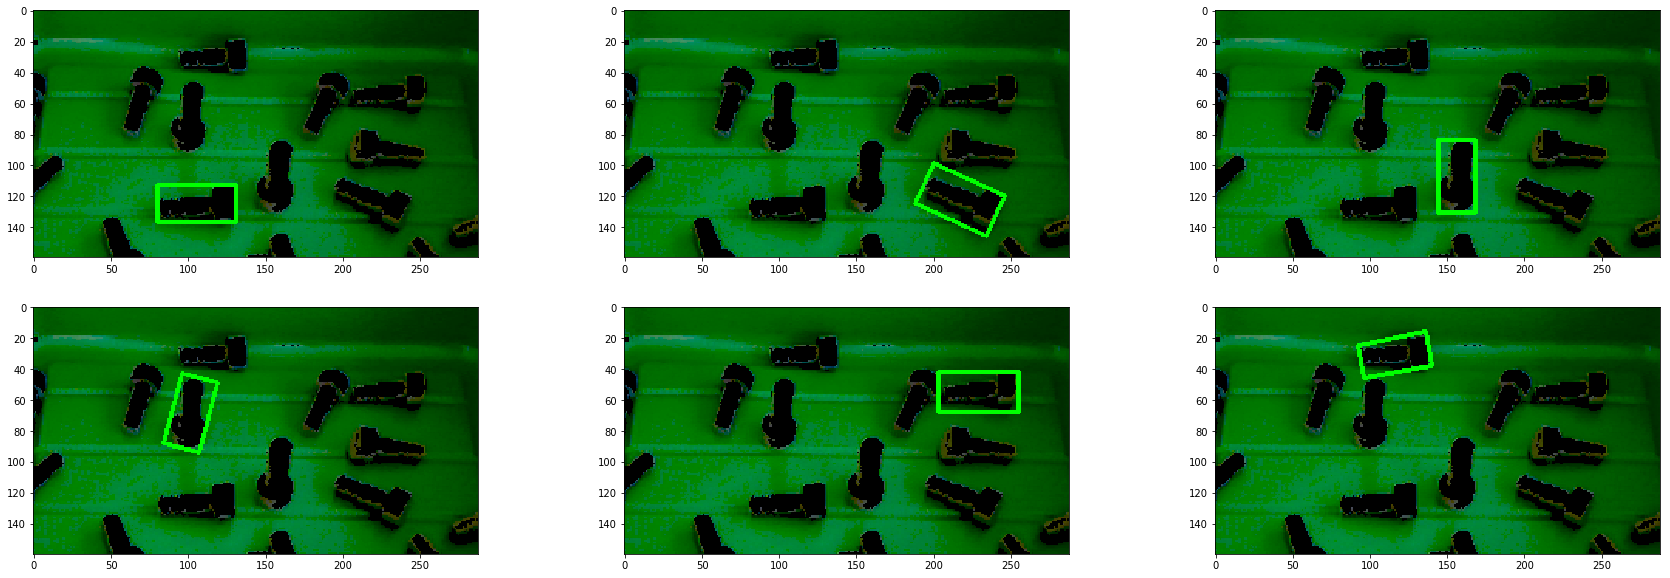

In [34]:
entities, meta = [], []
fig, ax = plt.subplots(figsize=(30,10), nrows=2, ncols=3)
for i, candidate in enumerate(candidates):
    x, y, angle, box = bounding_box(contours[candidate])
    entities.append(box)
    meta.append((x, y, angle))
    res2 = roi.copy()
    ax.flat[i].imshow(cv2.drawContours(res2, [entities[-1]], 0, (0, 255, 0), 2))

`(x, y, z)` give 3D pose wrt camera frame

In [35]:
K_TABLE_HEIGHT = np.inf # unknown

In [36]:
i_best = np.argmax([score(x, y, angle) for (x, y, angle) in meta])
x = int(meta[i_best][1] + roi_origin[0])
y = int(meta[i_best][0] + roi_origin[1])
z = min(depth_img[x, y], K_TABLE_HEIGHT)

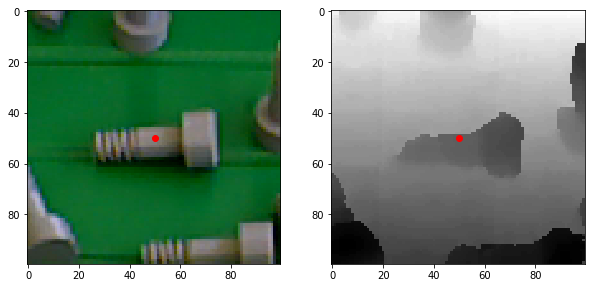

In [37]:
fig, ax = plt.subplots(figsize=(10, 5), nrows=1, ncols=2)
ax[0].imshow(rgb_img[x-50:x+50, y-50:y+50])
ax[1].imshow(depth_img[x-50:x+50, y-50:y+50], cmap='gray')
for axes in ax:
    axes.plot(50, 50, 'o', color='r')
plt.show()

you must run `roscore` first

publish a `tf` to get the correct transforms

only run `init_node` once

In [38]:
rospy.init_node('test')
while not rospy.Time.now():
    pass
import time; time.sleep(5) # hotfix to let TF buffer fill
tfl = tf.TransformListener()

TODO make `camera` a class field, so `xyz_to_pose` can grab it

In [39]:
camera = img_geo.PinholeCameraModel() 
camera.fromCameraInfo(rospy.wait_for_message('/head_camera/depth/camera_info', CameraInfo))

In [62]:
# assumes a top-down grasp
def xyz_to_pose(x, y, z, src_frame='/base_link', dst_frame='/head_camera_rgb_optical_frame'):
    pose = PoseStamped()
    pose.header.frame_id = dst_frame
    pose.header.stamp = tfl.getLatestCommonTime(src_frame, dst_frame) #rospy.Time.now()
    pose.pose.position.x = x
    pose.pose.position.y = y
    pose.pose.position.z = z if z<=1000.0 else z/1000.0 # max depth range 1 meter
    pose.pose.orientation.w = 1.0
    tfl.waitForTransform(camera.tfFrame(), src_frame, tfl.getLatestCommonTime(src_frame, dst_frame), rospy.Duration(5.0))
    tf_point = tfl.transformPose(src_frame, pose)
    return tf_point